## Hybrid Retrieval and Agent Integration - PoC
Here, we will integrate the hybrid search retrieval mechanism with the Data-Analyst agent.

Let's get started.

In [1]:
import os
import io
import sys
import json
import traceback
import regex as re
import pandas as pd
from pyjstat import pyjstat
from textwrap import dedent
from pyjstat import pyjstat
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Dict, List, Any, Literal, Annotated

from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, AIMessage, ToolMessage
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId

In [2]:
from pathlib import Path
import os

root = Path().absolute().parents[1]
os.chdir(str(root))

In [3]:
llm_low = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_med = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_high  = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
def _run_python_safely(code: str) -> Dict[str, Any]:
    """
    Minimal sandbox runner. In production: isolate with subprocess, container, time & mem limits.
    Returns {"stdout": str, "error": {"type":, "message":, "trace":}} on failure.
    """
    stdout_capture = io.StringIO()
    old_stdout, old_stderr = sys.stdout, sys.stderr
    sys.stdout = stdout_capture
    sys.stderr = stdout_capture  # co-mingle
    globals_dict = {"__name__": "__main__"}
    try:
        exec(code, globals_dict, globals_dict)
        out = stdout_capture.getvalue()
        return {"stdout": out}
    except Exception as e:
        err = {"type": e.__class__.__name__, "message": str(e), "trace": traceback.format_exc()}
        return {"stdout": stdout_capture.getvalue(), "error": err}
    finally:
        sys.stdout, sys.stderr = old_stdout, old_stderr

@tool(name_or_callable="python_code_executor", parse_docstring=True)
def python_code_executor(
    code: str,
    description: str,
    state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """
    Executes the given Python code and returns the output.
    
    Args:
        code (str): The Python code to execute.
        description (str): A short description of the code being executed.
    
    Returns:
        str: The output of the executed code.
    """
    print("Executing code in python_code_executor: ", description)
    result = _run_python_safely(code)
    print("Result from python_code_executor: ", result['stdout'])

    if 'error' in result:
        return Command(
            update={
                "scratchpad": [
                    ToolMessage(
                        content=f"Error executing code: {result['error']}",
                        tool_call_id=tool_call_id,
                        name="python_code_executor"
                    )
                ],
            }
        )
    

    return Command(
        update={
            "scratchpad": [
                ToolMessage(
                    content=result['stdout'],
                    # content="Context updated with required analysis.",
                    tool_call_id=tool_call_id,
                    name="python_code_executor"
                )
            ],
        }
    )

TOOLS = [python_code_executor]

llm_med_with_code_exec_tool = llm_med.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])
llm_high_with_code_exec_tool = llm_high.bind_tools(TOOLS, allowed_function_names=["python_code_executor"])

In [5]:
class State(TypedDict):
    """State for the analyst agent."""
    scratchpad: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The scratchpad for the agent.")
    context: str = Field(default=None, description="The context for the agent to use.")
    iters: int = Field(default=0, description="The number of iterations the agent has gone through.")
    sub_question: str = Field(description="The question asked by the user.")
    table_id: str = Field(description="The ID of the table being queried.")
    # csv_fp: str = Field(default="", description="The file path to the CSV file containing the CSO data.")
    # code: str = Field(default="", description="The python code to run.")


In [6]:
from src.helpers.json_stat_archive_db import JSONStatArchiveDB

cso_archive_reader = JSONStatArchiveDB(compression_level=12)

In [7]:
SYSTEM_PROMPT_ANALYST = dedent(
    f"""\
        # ROLE: I am a Data Analyst Agent that has access to Python-shell tool/function - `python_code_executor(code: str, description: str)`.

        # INSTRUCTIONS:
            - I call the `python_code_executor` tool to analyse the data.
            - Once I feel I know enough, I give a crisp and concise answer to the user's question.

        # NOTE:
            - The python-script should import necessary libraries (pandas, numpy, os, pathlib, etc) to read the CSV file and perform data manipulation 
            - The python-script use `print` statements for printing any statistics that you need to fetch.
            - In a single tool-call to `python_code_executor`, I ask for a single statistic to be fetched.
            - I keep the commentary limited in this step.
            - Once I have enough statistics to answer the user's question, I give a crisp and concise answer to user's question, with proper data backing it up.
        
        # WARNINGS:
            - For tool-calls to `python_code_executor` tool, only send the python code as `code` parameter
            - Do not include any visualizations or plots in the code.
            - In case I get reported back with any errors in executing the python code, I should make necessary corrections and call the python_code_executor tool to re-run the code.
        
        # TIPS:
            - For high cardinality columns, consider using simple keyword based filtering (like `str.contains('abc|xyz')`). Also consider items / categories related to said keywords.
    """
)
def _create_table_analysis(df: pd.DataFrame, table_id: str) -> dict:
    """
    Analyzes the table and returns a dictionary with the analysis results.

    Args:
        df (pd.DataFrame): The DataFrame containing the CSO data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    csv_fp = f"cache/{table_id}.csv"
    try:
        table_shape = df.shape
        table_sample = pd.concat([df.head(5), df.tail(5)]) if len(df) > 10 else df
        
        table_info_df = pd.DataFrame({
            "columns": df.columns,
            "dtypes": [str(df[col].dtype) for col in df.columns],
            "nunique": [df[col].nunique() if df[col].nunique() <= 50 else '>50' for col in df.columns],
            "nulls": [df[col].isnull().sum() for col in df.columns]
        })

        context_list = [
            "CONTEXT:",
            f"- **CSV File Path**: {csv_fp}",
            f"- **Table Shape**: {table_shape}",
            "- **Table Info**:",
            table_info_df.to_string(index=False),
            "- **Table Sample (first and last 5 rows)**:",
            table_sample.to_string(index=False),
        ]

    except Exception as e:
        context_list = None

    return context_list

def analyst_agent(state: State) -> str:
    """
    The analyst agent has access to the Python-Shell tool and uses it answer the user query by analysing the data available in context.

    Args:
        state (State): The state containing the messages and other data.
    
    Returns:
        str: The response from the analyst agent.
    """
    sub_question = state["sub_question"]
    old_messages = state["scratchpad"]
    system_prompt = SYSTEM_PROMPT_ANALYST
    iters = state.get("iters", 0)
    table_id = state["table_id"]
    iters += 1

    csv_save_dir = "cache/"
    csv_fp = csv_save_dir + f"{table_id}.csv"

    # check if "<table_id>.csv" exists. If not, read the pyjstat-file from artifacts and save the DataFrame as "<table_id>.csv"
    if not os.path.exists(csv_fp):
        for _, ds, _ in cso_archive_reader.read("artifacts/cso_bkp/cso_archive/jsonstat_archive.sqlite", table_id=table_id, with_labels=True):
            df: pd.DataFrame = pyjstat.from_json_stat(ds)[0]
        df.to_csv(csv_fp, index=False)

    if state.get("context", None) is None:
        df = pd.read_csv(csv_fp)
        context_list = _create_table_analysis(df, table_id)
        context = "\n".join(context_list) if context_list else "No context available."
    else:
        context = state["context"]

    msgs = [
        SystemMessage(content=system_prompt, name="analyst_agent"),
        SystemMessage(content=context, name="analyst_agent"),
        HumanMessage(content=sub_question, name="analyst_agent"),
    ] + old_messages
    
    if iters <= 10:
        print("Running data-analyst agent...")
        res = llm_med_with_code_exec_tool.invoke(msgs)
    else:
        print("Stopping tool-calls as max-iterations reached. Generating final response...")
        res = llm_med.invoke(msgs)
        return {"scratchpad": [res], "iters": iters, "context": context}
    
    if isinstance(res, AIMessage):
        return {"scratchpad": [res], "iters": iters, "context": context}
    else:
        res = AIMessage("Error generating code.")
        return {"scratchpad": [res], "iters": iters, "context": context}


In [8]:
def has_tool_calls(msg: AIMessage) -> bool:
    """
    Check if the AIMessage has tool calls.
    
    Args:
        msg (AIMessage): The AI message to check.
    
    Returns:
        bool: True if the message has tool calls, False otherwise.
    """
    return getattr(msg, "tool_calls", None) is not None or \
           bool(getattr(msg, "additional_kwargs", {}).get("function_call") or \
                getattr(msg, "additional_kwargs", {}).get("tool_calls"))


def custom_tools_condition(state: State) -> bool:
    """
    Route the LLM based on tool calls in the last message.
    
    Args:
        state (State): The current state of the graph.
    
    Returns:
        str: "tools" if the last message has tool calls, "end" otherwise.
    """
    messages_key = "scratchpad"
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [9]:
tool_node = ToolNode(TOOLS, messages_key="scratchpad")

analyst_graph_builder = StateGraph(State)

analyst_graph_builder.add_node("analyst_agent", analyst_agent)
analyst_graph_builder.add_node("tools", tool_node)

analyst_graph_builder.add_edge(START, "analyst_agent")
analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"__end__": END, "tools": "tools"})
# analyst_graph_builder.add_conditional_edges("analyst_agent", custom_tools_condition, {"end": END, "tools": "tools"})
analyst_graph_builder.add_edge("tools", "analyst_agent")

analyst_graph = analyst_graph_builder.compile()
# analyst_graph

### Create parent graph for Analyst Agent
The parent graph will contain the `reviewer` agent. It will perform the following tasks -
- Retrieve upto top 20 relevant resources using the `HybridRetrieval` engine
- Select upto top 5 most relevant resources (table-IDs)
- Manually enforce tool-calls to the analyst-agent subgraph *(Note that we'll be using the analyst-agent as a tool)*
- The `reviewer` agent will have input and output transformation nodes, because the parent graph and the subgraph have separate state schemas (read the official [LangGraph documentation](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#using-different-state-schemas) for more details)

Let's build it.

In [10]:
from pydantic import BaseModel, Field


class ParentState(TypedDict):
    """State for the parent graph."""
    messages: Annotated[list[BaseMessage], add_messages] = Field(default=[], description="The messages for the parent graph.")
    question: str = Field(description="The question asked by the user.")
    iter: int = Field(default=0, description="The iteration count for the current state.")


class TableSelectionSubclass(BaseModel):
    table_id: str = Field(description="Table ID.")
    explanation: str = Field(description="Concise 1-liner explanation behind why this table is relevant.")


class TableSelection(BaseModel):
    relevant_tables: list[TableSelectionSubclass] = Field(description="List of relevant tables with explanations.")


In [11]:
from src.helpers.hybrid_retrieval import HybridRetrieval


retriever = HybridRetrieval(top_k_stage_1=200, top_k_stage_2=20)

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from textwrap import dedent
from uuid import uuid4


def _create_context(table_ids: list) -> str:
    context = []
    for table_id in table_ids:
        doc = retriever.vector_store.docstore.search(table_id)
        sample_questions_str = "\n  - ".join(doc.metadata["sample_questions"])
        text_chunk_list = [
            f"**Table ID**: {doc.id}",
            f"**Table Name (and Category)**: {doc.metadata['table_name']} ({doc.metadata['subject']}: {doc.metadata['product']})",
            f"**Table Summary**: {doc.metadata['description']}",
            f"**Fields**: {', '.join(doc.metadata['columns'])}",
            f"**Sample Questions**:",
            f"  - {sample_questions_str}"
        ]
        text_chunk = "\n".join(text_chunk_list)
        context.append(text_chunk)
    return "\n\n".join(context)

def reviewer_agent(state: ParentState):
    messages = state["messages"]
    question = state["question"]
    iter = state.get("iter", 0) + 1
    
    if messages and isinstance(messages[-1], ToolMessage):
        msgs = [
            SystemMessage(content="I'm a helpful assistant. My job is to answer the user-question given the context in detail, using all the facts available. Also, specify the sources (table-IDs would be best)"),
            HumanMessage(content=question),
        ] + messages
        summary_res = llm_med.invoke(msgs)
        return {
            "messages": [summary_res],
            "iter": iter
        }

    print("REVIEWER_AGENT: Running Hybrid Retrieval...")
    # response = retriever.search(query=question)
    # top_20_table_ids = response.sort_values(by="stage_2_score", ascending=True)[:20]["id"].tolist()
    # print(f"REVIEWER_AGENT: Hybrid Retrieval fetched {len(top_20_table_ids)} table IDs")
    # context = _create_context(top_20_table_ids)
    # prompt_list = [
    #     "Given the following tables context, select up to 3 of the possible relevant tables based on the question asked.",
    #     "",
    #     "Table context:",
    #     context,
    #     "",
    #     "question: " + question,
    # ]
    # prompt = "\n".join(prompt_list)
    # response = llm_med.with_structured_output(TableSelection).invoke(prompt)
    # response_dict = response.model_dump()

    # relevant_tables_ids = [
    #     item["table_id"] for item in response_dict["relevant_tables"]
    # ]
    relevant_tables_ids = retriever.search(query=question)
    print(f"REVIEWER_AGENT: LLM selected {len(relevant_tables_ids)} relevant tables.")

    if iter > 2:
        print("REVIEWER_AGENT: Iteration limit reached.")
        return {
            "messages": [AIMessage(content="Max iteration limit reached.")],
            "iter": iter
        }
    
    if not relevant_tables_ids:
        print("REVIEWER_AGENT: No relevant tables found.")
        return {
            "messages": [AIMessage(content="No relevant tables found.")],
            "iter": iter
        }
    else:
        print(f"REVIEWER_AGENT: Making tool calls...")
        tool_calls = [
            {
                "name": "data_analyst_tool",
                "args": {
                    "table_id": id,
                    "question": question
                },
                "id": str(uuid4())
            } for id in relevant_tables_ids
        ]
        return {
            "messages": [AIMessage(content="I've found some relevant resources. Let me do a quick analysis.", tool_calls=tool_calls)],
            "iter": iter
        }

def summariser_agent(state: ParentState):
    msgs = state["messages"]
    res = llm_med.invoke(msgs)
    return {
        "messages": [res],
    }


In [13]:
def custom_parent_tools_condition(state: State) -> bool:
    """
    Route the LLM based on tool calls in the last message.
    
    Args:
        state (State): The current state of the graph.
    
    Returns:
        str: "tools" if the last message has tool calls, "summariser_agent" otherwise.
    """
    messages_key = "messages"

    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "summariser_agent"

@tool("data_analyst_tool", parse_docstring=True)
def data_analyst_tool(
    table_id: str,
    question: str,
    # state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """
    Tool to invoke the data analyst agent with a specific table ID and question.
    
    Args:
        table_id (str): The ID of the table to analyze.
        question (str): The question to ask the data analyst.

    Returns:
        Command: The command to update the chat with the data analyst's response.
    """
    print("DATA_ANALYST_TOOL: Invoking data analyst tool...")
    res = analyst_graph.invoke({"table_id": table_id, "sub_question": question})
    last_message = res["scratchpad"][-1]
    print("DATA_ANALYST_TOOL: Run Successfully")
    return Command(
        update={
            "messages": [
                ToolMessage(
                    content=last_message.content,
                    tool_call_id=tool_call_id,
                    name="data_analyst_tool",
                )
            ]
        }
    )

TOOLS = [data_analyst_tool]

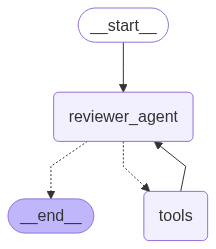

In [14]:
tool_node = ToolNode(TOOLS)

parent_graph_builder = StateGraph(ParentState)

parent_graph_builder.add_node("reviewer_agent", reviewer_agent)
# parent_graph_builder.add_node("summariser_agent", summariser_agent)
parent_graph_builder.add_node("tools", tool_node)

parent_graph_builder.add_edge(START, "reviewer_agent")
parent_graph_builder.add_conditional_edges("reviewer_agent", tools_condition)
# parent_graph_builder.add_conditional_edges("reviewer_agent", custom_parent_tools_condition, {"summariser_agent": "summariser_agent", "tools": "tools"})
parent_graph_builder.add_edge("tools", "reviewer_agent")

app = parent_graph_builder.compile()
app

In [15]:
question = "QUESTION: Give me the breakdown of renewable energy resources as a percentage share and absolute numbers in 2022 in ireland."
question = "QUESTION: How's the energy production in ireland over the years? Do a detailed comparison of renewable vs non-renewable share of energy"
# question = "QUESTION: How's the wind energy production over the years?"
question = "QUESTION: Did the Ukraine war have any impact on the energy production in ireland??"
# question = "QUESTION: How has nuclear energy done over the years in ireland?"
# question = "QUESTION: What's the impact of climate change on energy production in ireland?"
# question = "QUESTION: How's the energy production in ireland over 2021-2025? Do a detailed comparison of renewable vs non-renewable share of energy"
question = "QUESTION: What's the total agricultural area in Ireland?"
# question = "detailed statistics on cosmetics, toileteries and related items production in prodcom data for ireland"
# question = "detailed statistics on lignin based products and related items production in prodcom data for ireland"
# question = "Population growth in ireland over the last 2 decades?"



res = app.invoke({"question": question})

I0000 00:00:1755861994.693772 1651461 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


REVIEWER_AGENT: Running Hybrid Retrieval...


REVIEWER_AGENT: LLM selected 3 relevant tables.
REVIEWER_AGENT: Making tool calls...
DATA_ANALYST_TOOL: Invoking data analyst tool...
DATA_ANALYST_TOOL: Invoking data analyst tool...
DATA_ANALYST_TOOL: Invoking data analyst tool...
Running data-analyst agent...
Running data-analyst agent...
Running data-analyst agent...
Executing code in python_code_executor:  Get unique values of "Type of Land Use" column
Result from python_code_executor:  ['Area farmed (AAU)' 'Crops and pasture' 'Pasture' 'Hay' 'Grass silage'
 'Total crops, fruit and horticulture' 'Beans and peas' 'Oilseed rape'
 'Arable silage' 'Maize silage' 'Fodder rape and kale' 'Potatoes'
 'Turnips' 'Beet' 'Vegetables for sale' 'Fruit'
 'Nurseries, horticulture etc.' 'Other crops' 'Total cereals'
 'Total wheat' 'Winter wheat' 'Spring wheat' 'Total oats' 'Winter oats'
 'Spring oats' 'Total barley' 'Winter barley' 'Spring barley'
 'Other cereals' 'Rough grazing in use']

Running data-analyst agent...
Executing code in python_code_

In [27]:
res["messages"]

[AIMessage(content="I've found some relevant resources. Let me do a quick analysis.", additional_kwargs={}, response_metadata={}, id='84c6383c-2468-43f2-983c-24b48bd91e72', tool_calls=[{'name': 'data_analyst_tool', 'args': {'table_id': 'AQA06', 'question': "QUESTION: What's the total agricultural area in Ireland?"}, 'id': '27f78793-8abd-4549-9413-c42ae4f87bde', 'type': 'tool_call'}, {'name': 'data_analyst_tool', 'args': {'table_id': 'AVA33', 'question': "QUESTION: What's the total agricultural area in Ireland?"}, 'id': 'eaebbb4e-6f92-4ece-8bd8-0bd99865c35c', 'type': 'tool_call'}, {'name': 'data_analyst_tool', 'args': {'table_id': 'IFS10', 'question': "QUESTION: What's the total agricultural area in Ireland?"}, 'id': 'a9262b90-4bfe-4226-94ba-60472dc455f1', 'type': 'tool_call'}]),
 ToolMessage(content='The total agricultural area in Ireland is 53543.683 hectares.', name='data_analyst_tool', id='b792218e-cdff-4a70-8200-3d5cc8fd649c', tool_call_id='27f78793-8abd-4549-9413-c42ae4f87bde'),
 

In [28]:
print(res["messages"][-1].content)

In [29]:
q = res["messages"][-1].content

In [30]:
q

'Based on the information available:\n\n*   The total agricultural area in Ireland is **53,543.683 hectares** (Source: AQA06).\n*   Another source indicates the total agricultural area in Ireland is **416,415.0 hectares** (Source: AVA33).\n*   Furthermore, the total agricultural area in Ireland was **4,509,256.2 hectares in 2020** and **4,620,095.9 hectares in 2023** (Source: IFS10).\n\nThere are discrepancies in the reported total agricultural area across different sources.'

## Fixing context-isolation problem

state:
    - messages: List[str]
    - relevant_docs: List[Dict]
        - table_id: str
        - context: str
        - analysis_plan: str
    - question: str
    - iter: int
         
reviewer-agent
    - has access to data-cso hybrid-retrieval tool - given a user prompt, it may choose to call this hybrid-retrieval tool. This tool updates the `relevant_docs` in state, and also returns a ToolMessage containing all context for all tables it retrieved
    - it also has access to the planner tool, which is basically an agent. it takes in the `messages`, creates a low-level plan for each data-source analysis and updates the `relevant_docs` with the plan. Also it returns a ToolMessage containing the plan for all tables
    - finally, it has access to the data-analyst subgraph as a tool. It can make multiple tool-calls to this tool. The tool node containing this subgraph will call the subgraph with the `table_id`, `question`, `analysis_plan`, and the `context`.

Giving this level of autonomy may have the following effect:
- Pros: context-isolation problem may be fixed
- Cons: redundant recursive loops, uncertainty in making tool-calls / malformed tool-calls, hallucinations, or even premature answering